<a href="https://colab.research.google.com/github/yutayuta7890/ichiyasaGitSample/blob/master/boidmodel_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 最新コード


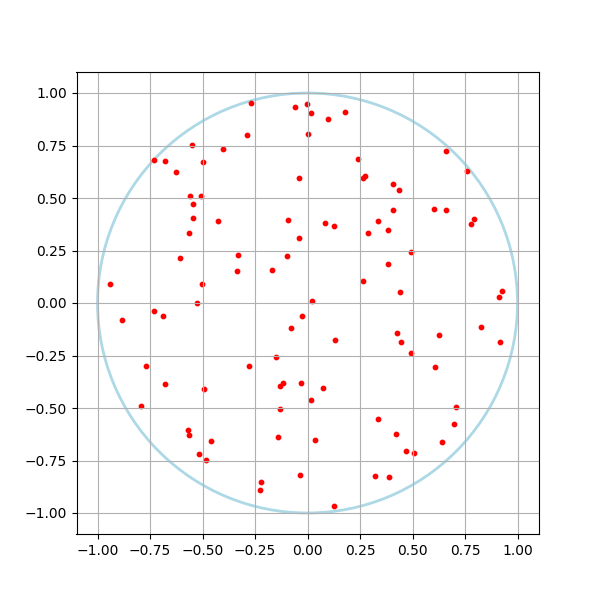

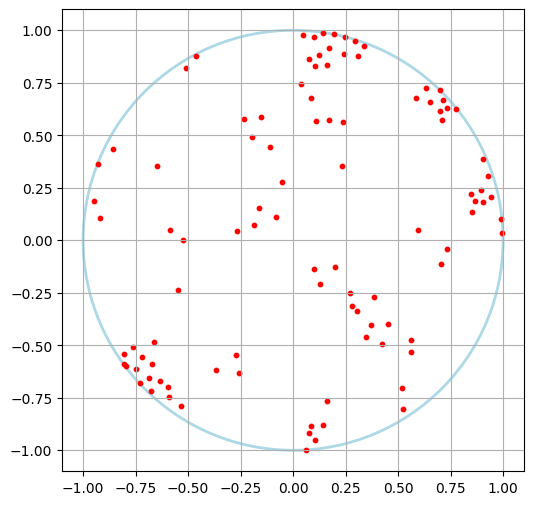

In [6]:
# Colab環境では初回のみ実行してください
!pip install numba

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image
from numba import njit

# ======== パラメータまとめ ========
params = {
    "num_points": 100,             # 点の数
    "radius": 1.0,                 # 円の半径
    "dt": 0.05,                    # 時間刻み
    "neighbor_radius": 0.05,       # 近傍判定の距離
    "alignment_weight": 0.1,       # 整列の重み
    "cohesion_weight": 0.01,       # 結合の重み
    "separation_weight": 0.001,    # 分離の重み
    "max_speed": 0.1,              # 最大速度
    "initial_speed": 0.1,          # 初期速度
    "frames": 300,                 # フレーム数を3倍に
    "interval": 50,                # 各フレーム間の表示時間（ms）
    "fps": 20,                     # GIF保存時のフレームレート（変えない）
    "gif_name": "swarm_motion_numba.gif"
}


# パラメータ展開
num_points = params["num_points"]
radius = params["radius"]
dt = params["dt"]
neighbor_radius = params["neighbor_radius"]
alignment_weight = params["alignment_weight"]
cohesion_weight = params["cohesion_weight"]
separation_weight = params["separation_weight"]
max_speed = params["max_speed"]
initial_speed = params["initial_speed"]
frames = params["frames"]
interval = params["interval"]
fps = params["fps"]
gif_name = params["gif_name"]

# ======== 初期位置と速度の設定 ========
# 点の初期位置を円内のランダムな位置に設定
angles = np.random.uniform(0, 2 * np.pi, num_points)   # 角度
radii = np.sqrt(np.random.uniform(0, 1, num_points)) * radius  # 半径（均等分布になるように平方根を使用）
x = radii * np.cos(angles)  # x座標
y = radii * np.sin(angles)  # y座標

# 点の初期速度をランダムな方向に設定（大きさはinitial_speed）
vel_angles = np.random.uniform(0, 2 * np.pi, num_points)
vx = initial_speed * np.cos(vel_angles)
vy = initial_speed * np.sin(vel_angles)

# ======== 速度更新を高速化するnumba関数 ========
@njit
def update_velocity_numba(x, y, vx, vy, num_points, neighbor_radius,
                          alignment_weight, cohesion_weight, separation_weight, max_speed):
    # 新しい速度を入れる配列を作成
    new_vx = vx.copy()
    new_vy = vy.copy()

    for i in range(num_points):
        neighbors = []  # 近傍の仲間のインデックスリスト

        # 近傍判定：全ての点と距離を比較して近いものを探す
        for j in range(num_points):
            if i != j:
                dx = x[j] - x[i]
                dy = y[j] - y[i]
                dist = np.sqrt(dx*dx + dy*dy)
                if dist < neighbor_radius:
                    neighbors.append(j)

        if len(neighbors) > 0:
            # 近傍の平均速度、平均位置、斥力計算用変数
            avg_vx = 0.0
            avg_vy = 0.0
            avg_x = 0.0
            avg_y = 0.0
            repulsion_x = 0.0
            repulsion_y = 0.0

            # 近傍の速度と位置の和を計算
            for n in neighbors:
                avg_vx += vx[n]
                avg_vy += vy[n]
                avg_x += x[n]
                avg_y += y[n]

            # 平均を求める
            avg_vx /= len(neighbors)
            avg_vy /= len(neighbors)
            avg_x /= len(neighbors)
            avg_y /= len(neighbors)

            # 整列：自身の速度を近傍の平均速度に近づける
            new_vx[i] += alignment_weight * (avg_vx - vx[i])
            new_vy[i] += alignment_weight * (avg_vy - vy[i])

            # 結合：近傍の平均位置に近づく
            new_vx[i] += cohesion_weight * (avg_x - x[i])
            new_vy[i] += cohesion_weight * (avg_y - y[i])

            # 分離：近すぎる仲間から離れる（斥力）
            for n in neighbors:
                diff_x = x[i] - x[n]
                diff_y = y[i] - y[n]
                dist = np.sqrt(diff_x*diff_x + diff_y*diff_y) + 1e-4  # 0除算防止
                repulsion_x += diff_x / dist
                repulsion_y += diff_y / dist

            new_vx[i] += separation_weight * repulsion_x
            new_vy[i] += separation_weight * repulsion_y

    # 速度制限（最大速度を超えたらスケーリング）
    for i in range(num_points):
        speed = np.sqrt(new_vx[i]**2 + new_vy[i]**2)
        if speed > max_speed:
            new_vx[i] = new_vx[i] / speed * max_speed
            new_vy[i] = new_vy[i] / speed * max_speed

    return new_vx, new_vy

# ======== 描画準備 ========
fig, ax = plt.subplots(figsize=(6, 6))
circle = plt.Circle((0, 0), radius, color='lightblue', fill=False, linewidth=2)
ax.add_artist(circle)   # 円を描画
scat = ax.scatter(x, y, color='red', s=10)  # 点を描画
ax.set_xlim(-1.1 * radius, 1.1 * radius)
ax.set_ylim(-1.1 * radius, 1.1 * radius)
ax.set_aspect('equal')  # アスペクト比1:1に
plt.grid(True)

# ======== フレーム更新関数 ========
def update(frame):
    global x, y, vx, vy

    # 速度を群知能ルールに従って更新（numba高速化関数を使用）
    vx, vy = update_velocity_numba(x, y, vx, vy, num_points,
                                  neighbor_radius,
                                  alignment_weight,
                                  cohesion_weight,
                                  separation_weight,
                                  max_speed)

    # 位置を速度に従って更新
    x += vx * dt
    y += vy * dt

    # 円の外に出た点は反射させる
    for i in range(num_points):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist >= radius:
            # 法線ベクトル（円の中心から点へのベクトルの単位ベクトル）
            normal = np.array([x[i], y[i]]) / dist
            velocity = np.array([vx[i], vy[i]])
            # 反射ベクトル計算
            reflected = velocity - 2 * np.dot(velocity, normal) * normal
            vx[i], vy[i] = reflected
            # 重なり分だけ位置修正して円内に戻す
            overlap = dist - radius
            x[i] -= 2 * overlap * normal[0]
            y[i] -= 2 * overlap * normal[1]

    scat.set_offsets(np.c_[x, y])  # 点の位置更新
    return scat,

# ======== アニメーション作成・保存・表示 ========
ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
ani.save(gif_name, writer=PillowWriter(fps=fps))

Image(open(gif_name, "rb").read())


# Try コード

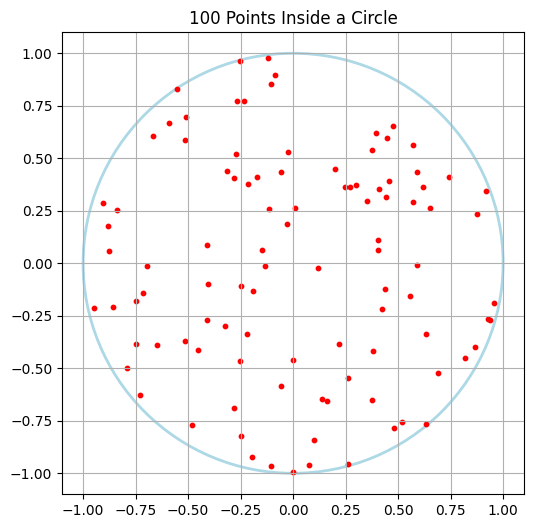

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 点の数
num_points = 100
radius = 1  # 円の半径（原点中心）

# ランダムな角度と距離を生成（極座標）
angles = np.random.uniform(0, 2 * np.pi, num_points)
radii = np.sqrt(np.random.uniform(0, 1, num_points)) * radius

# 極座標 → デカルト座標
x = radii * np.cos(angles)
y = radii * np.sin(angles)

# 描画
fig, ax = plt.subplots(figsize=(6, 6))
circle = plt.Circle((0, 0), radius, color='lightblue', fill=False, linewidth=2)
ax.add_artist(circle)
ax.scatter(x, y, color='red', s=10)

# 描画設定
ax.set_xlim(-1.1 * radius, 1.1 * radius)
ax.set_ylim(-1.1 * radius, 1.1 * radius)
ax.set_aspect('equal')
ax.set_title("100 Points Inside a Circle")
plt.grid(True)
plt.show()


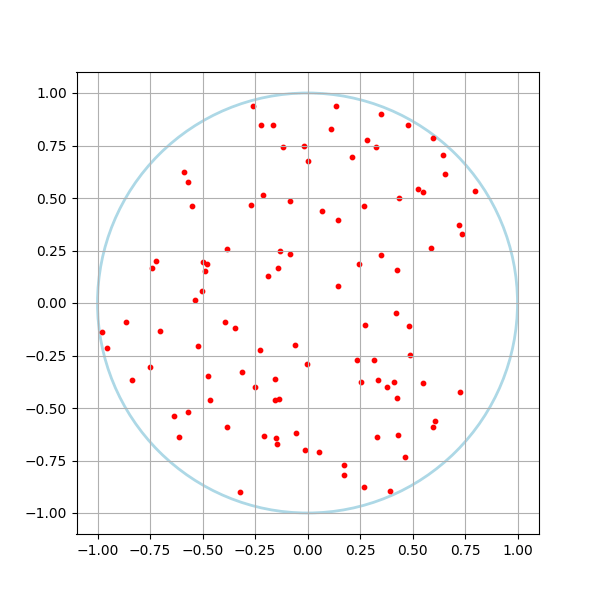

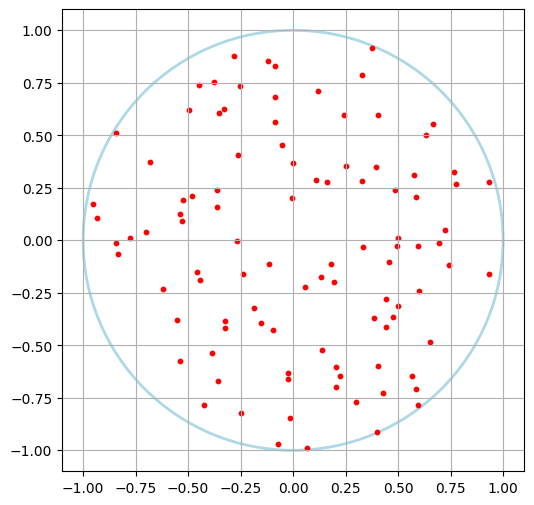

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# 点の数と円の半径
num_points = 100
radius = 1.0

# 初期位置（円内に均等に配置）
angles = np.random.uniform(0, 2 * np.pi, num_points)
radii = np.sqrt(np.random.uniform(0, 1, num_points)) * radius
x = radii * np.cos(angles)
y = radii * np.sin(angles)

# 各点の速度ベクトル（ランダムな方向に等速）
speed = 0.02
vel_angles = np.random.uniform(0, 2 * np.pi, num_points)
vx = speed * np.cos(vel_angles)
vy = speed * np.sin(vel_angles)

# 描画の準備
fig, ax = plt.subplots(figsize=(6, 6))
circle = plt.Circle((0, 0), radius, color='lightblue', fill=False, linewidth=2)
ax.add_artist(circle)
scat = ax.scatter(x, y, color='red', s=10)
ax.set_xlim(-1.1 * radius, 1.1 * radius)
ax.set_ylim(-1.1 * radius, 1.1 * radius)
ax.set_aspect('equal')
plt.grid(True)

def update(frame):
    global x, y, vx, vy
    x += vx
    y += vy
    for i in range(num_points):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist >= radius:
            normal = np.array([x[i], y[i]]) / dist
            velocity = np.array([vx[i], vy[i]])
            reflected = velocity - 2 * np.dot(velocity, normal) * normal
            vx[i], vy[i] = reflected
            overlap = dist - radius
            x[i] -= 2 * overlap * normal[0]
            y[i] -= 2 * overlap * normal[1]
    scat.set_offsets(np.c_[x, y])
    return scat,

# アニメーション生成
ani = FuncAnimation(fig, update, frames=100, interval=50, blit=True)

# GIFに保存
ani.save("moving_points.gif", writer=PillowWriter(fps=20))

# Colab上で表示
from IPython.display import Image
Image(open("moving_points.gif", "rb").read())


群知能ルール	説明
整列 (Alignment)	近くの点の速度の平均に合わせる
結合 (Cohesion)	近くの点の位置の中心に向かって移動
分離 (Separation)	近すぎる点から離れるように移動
境界処理	円の中に留まるよう反射

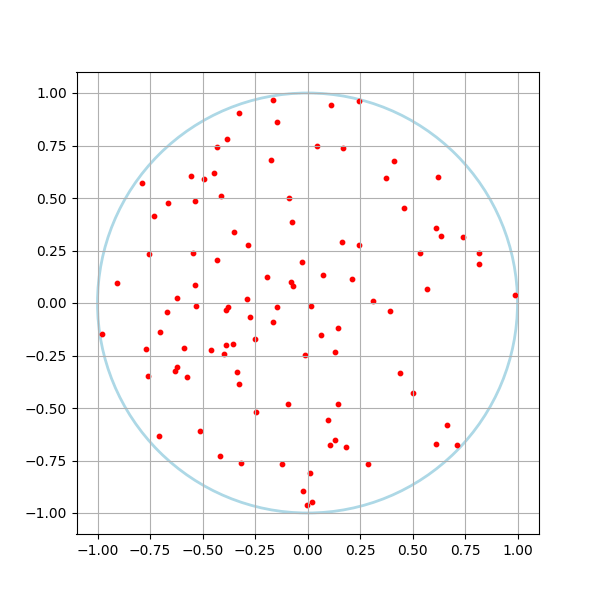

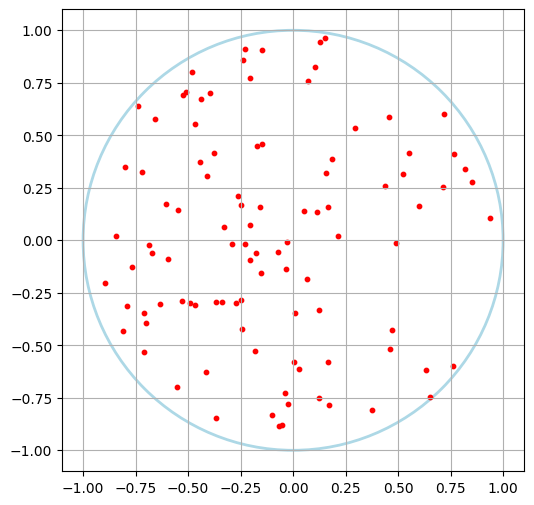

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image

# パラメータ
num_points = 100
radius = 1.0
dt = 0.05
neighbor_radius = 0.01  # 群知能の範囲
alignment_weight = 0.05
cohesion_weight = 0.01
separation_weight = 0.1
max_speed = 0.03

# 初期位置（円内ランダム）
angles = np.random.uniform(0, 2 * np.pi, num_points)
radii = np.sqrt(np.random.uniform(0, 1, num_points)) * radius
x = radii * np.cos(angles)
y = radii * np.sin(angles)

# 初期速度（ランダム）
vel_angles = np.random.uniform(0, 2 * np.pi, num_points)
vx = 0.02 * np.cos(vel_angles)
vy = 0.02 * np.sin(vel_angles)

# 描画
fig, ax = plt.subplots(figsize=(6, 6))
circle = plt.Circle((0, 0), radius, color='lightblue', fill=False, linewidth=2)
ax.add_artist(circle)
scat = ax.scatter(x, y, color='red', s=10)
ax.set_xlim(-1.1 * radius, 1.1 * radius)
ax.set_ylim(-1.1 * radius, 1.1 * radius)
ax.set_aspect('equal')
plt.grid(True)

def limit_speed(vx, vy, max_speed):
    speed = np.sqrt(vx**2 + vy**2)
    factor = np.ones_like(speed)
    factor[speed > max_speed] = max_speed / speed[speed > max_speed]
    return vx * factor, vy * factor

def update(frame):
    global x, y, vx, vy

    new_vx = np.copy(vx)
    new_vy = np.copy(vy)

    for i in range(num_points):
        neighbors = []
        for j in range(num_points):
            if i != j:
                dist = np.sqrt((x[j] - x[i])**2 + (y[j] - y[i])**2)
                if dist < neighbor_radius:
                    neighbors.append(j)

        if neighbors:
            # 1. 整列
            avg_vx = np.mean(vx[neighbors])
            avg_vy = np.mean(vy[neighbors])
            new_vx[i] += alignment_weight * (avg_vx - vx[i])
            new_vy[i] += alignment_weight * (avg_vy - vy[i])

            # 2. 結合
            avg_x = np.mean(x[neighbors])
            avg_y = np.mean(y[neighbors])
            new_vx[i] += cohesion_weight * (avg_x - x[i])
            new_vy[i] += cohesion_weight * (avg_y - y[i])

            # 3. 分離
            diff_x = x[i] - x[neighbors]
            diff_y = y[i] - y[neighbors]
            distances = np.sqrt(diff_x**2 + diff_y**2) + 1e-4
            repulsion_x = np.sum(diff_x / distances)
            repulsion_y = np.sum(diff_y / distances)
            new_vx[i] += separation_weight * repulsion_x
            new_vy[i] += separation_weight * repulsion_y

    # 速度制限
    vx, vy = limit_speed(new_vx, new_vy, max_speed)

    # 位置更新
    x += vx * dt
    y += vy * dt

    # 円の壁に衝突したら反射
    for i in range(num_points):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist >= radius:
            normal = np.array([x[i], y[i]]) / dist
            velocity = np.array([vx[i], vy[i]])
            reflected = velocity - 2 * np.dot(velocity, normal) * normal
            vx[i], vy[i] = reflected
            overlap = dist - radius
            x[i] -= 2 * overlap * normal[0]
            y[i] -= 2 * overlap * normal[1]

    scat.set_offsets(np.c_[x, y])
    return scat,

# アニメーション生成とGIF保存
ani = FuncAnimation(fig, update, frames=100, interval=50, blit=True)
ani.save("swarm_motion.gif", writer=PillowWriter(fps=20))
Image(open("swarm_motion.gif", "rb").read())


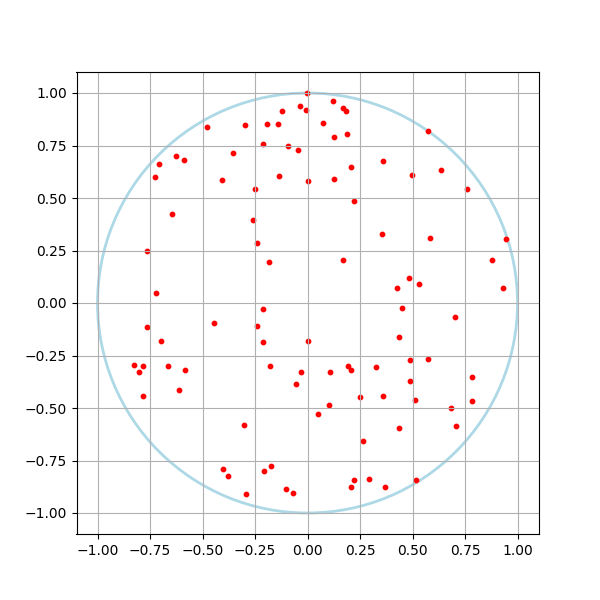

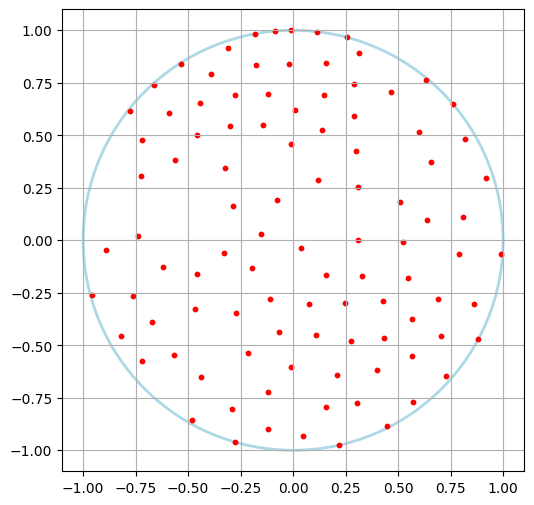

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image

# ======== ここにパラメータをまとめて記述 ========
params = {
    "num_points": 100,              # 粒子数
    "radius": 1.0,                  # 円の半径
    "dt": 0.05,                    # 時間刻み
    "neighbor_radius": 0.15,        # 群知能の近傍範囲
    "alignment_weight": 0.05,       # 整列の強さ
    "cohesion_weight": 0.01,        # 結合の強さ
    "separation_weight": 0.1,       # 分離の強さ
    "max_speed": 0.03,              # 最大速度
    "initial_speed": 0.02,          # 初期速度の大きさ
    "frames": 100,                  # アニメーションフレーム数
    "interval": 50,                 # フレーム間隔（ミリ秒）
    "gif_name": "swarm_motion.gif" # GIF保存ファイル名
}

# ======== 初期設定 ========
num_points = params["num_points"]
radius = params["radius"]
dt = params["dt"]
neighbor_radius = params["neighbor_radius"]
alignment_weight = params["alignment_weight"]
cohesion_weight = params["cohesion_weight"]
separation_weight = params["separation_weight"]
max_speed = params["max_speed"]
initial_speed = params["initial_speed"]
frames = params["frames"]
interval = params["interval"]
gif_name = params["gif_name"]

# 初期位置（円内ランダム）
angles = np.random.uniform(0, 2 * np.pi, num_points)
radii = np.sqrt(np.random.uniform(0, 1, num_points)) * radius
x = radii * np.cos(angles)
y = radii * np.sin(angles)

# 初期速度（ランダム方向）
vel_angles = np.random.uniform(0, 2 * np.pi, num_points)
vx = initial_speed * np.cos(vel_angles)
vy = initial_speed * np.sin(vel_angles)

# 描画設定
fig, ax = plt.subplots(figsize=(6, 6))
circle = plt.Circle((0, 0), radius, color='lightblue', fill=False, linewidth=2)
ax.add_artist(circle)
scat = ax.scatter(x, y, color='red', s=10)
ax.set_xlim(-1.1 * radius, 1.1 * radius)
ax.set_ylim(-1.1 * radius, 1.1 * radius)
ax.set_aspect('equal')
plt.grid(True)

def limit_speed(vx, vy, max_speed):
    speed = np.sqrt(vx**2 + vy**2)
    factor = np.ones_like(speed)
    factor[speed > max_speed] = max_speed / speed[speed > max_speed]
    return vx * factor, vy * factor

def update(frame):
    global x, y, vx, vy

    new_vx = np.copy(vx)
    new_vy = np.copy(vy)

    for i in range(num_points):
        neighbors = []
        for j in range(num_points):
            if i != j:
                dist = np.sqrt((x[j] - x[i])**2 + (y[j] - y[i])**2)
                if dist < neighbor_radius:
                    neighbors.append(j)

        if neighbors:
            # 整列
            avg_vx = np.mean(vx[neighbors])
            avg_vy = np.mean(vy[neighbors])
            new_vx[i] += alignment_weight * (avg_vx - vx[i])
            new_vy[i] += alignment_weight * (avg_vy - vy[i])

            # 結合
            avg_x = np.mean(x[neighbors])
            avg_y = np.mean(y[neighbors])
            new_vx[i] += cohesion_weight * (avg_x - x[i])
            new_vy[i] += cohesion_weight * (avg_y - y[i])

            # 分離
            diff_x = x[i] - x[neighbors]
            diff_y = y[i] - y[neighbors]
            distances = np.sqrt(diff_x**2 + diff_y**2) + 1e-4
            repulsion_x = np.sum(diff_x / distances)
            repulsion_y = np.sum(diff_y / distances)
            new_vx[i] += separation_weight * repulsion_x
            new_vy[i] += separation_weight * repulsion_y

    vx, vy = limit_speed(new_vx, new_vy, max_speed)

    x += vx * dt
    y += vy * dt

    # 円の壁で反射
    for i in range(num_points):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist >= radius:
            normal = np.array([x[i], y[i]]) / dist
            velocity = np.array([vx[i], vy[i]])
            reflected = velocity - 2 * np.dot(velocity, normal) * normal
            vx[i], vy[i] = reflected
            overlap = dist - radius
            x[i] -= 2 * overlap * normal[0]
            y[i] -= 2 * overlap * normal[1]

    scat.set_offsets(np.c_[x, y])
    return scat,

# アニメーション生成＆GIF保存
ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
ani.save(gif_name, writer=PillowWriter(fps=20))

# ColabでGIF表示
Image(open(gif_name, "rb").read())


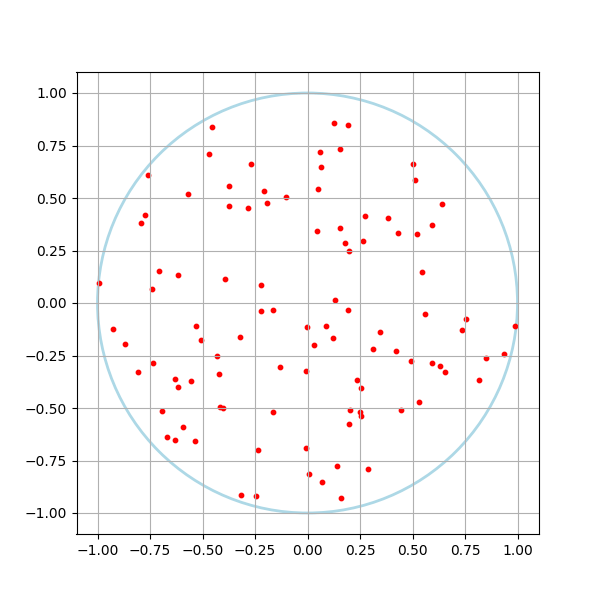

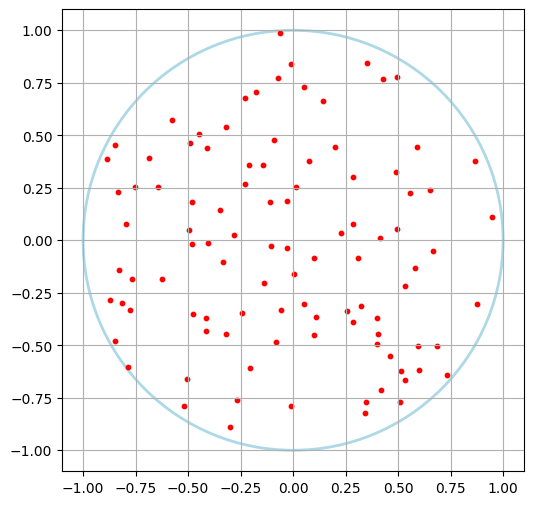

In [3]:
# Colabなら初回だけ実行
!pip install numba

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image
from numba import njit

# ======== パラメータまとめ ========
params = {
    "num_points": 100,
    "radius": 1.0,
    "dt": 0.1,
    "neighbor_radius": 0.05,
    "alignment_weight": 0.05,
    "cohesion_weight": 0.01,
    "separation_weight": 0.01,
    "max_speed": 0.1,
    "initial_speed": 0.05,
    "frames": 100,
    "interval": 50,       # ms
    "fps": 20,            # GIFのfps
    "gif_name": "swarm_motion_numba.gif"
}

num_points = params["num_points"]
radius = params["radius"]
dt = params["dt"]
neighbor_radius = params["neighbor_radius"]
alignment_weight = params["alignment_weight"]
cohesion_weight = params["cohesion_weight"]
separation_weight = params["separation_weight"]
max_speed = params["max_speed"]
initial_speed = params["initial_speed"]
frames = params["frames"]
interval = params["interval"]
fps = params["fps"]
gif_name = params["gif_name"]

# 初期位置・速度
angles = np.random.uniform(0, 2 * np.pi, num_points)
radii = np.sqrt(np.random.uniform(0, 1, num_points)) * radius
x = radii * np.cos(angles)
y = radii * np.sin(angles)

vel_angles = np.random.uniform(0, 2 * np.pi, num_points)
vx = initial_speed * np.cos(vel_angles)
vy = initial_speed * np.sin(vel_angles)

@njit
def update_velocity_numba(x, y, vx, vy, num_points, neighbor_radius,
                          alignment_weight, cohesion_weight, separation_weight, max_speed):
    new_vx = vx.copy()
    new_vy = vy.copy()

    for i in range(num_points):
        neighbors = []
        for j in range(num_points):
            if i != j:
                dx = x[j] - x[i]
                dy = y[j] - y[i]
                dist = np.sqrt(dx*dx + dy*dy)
                if dist < neighbor_radius:
                    neighbors.append(j)

        if len(neighbors) > 0:
            avg_vx = 0.0
            avg_vy = 0.0
            avg_x = 0.0
            avg_y = 0.0
            repulsion_x = 0.0
            repulsion_y = 0.0

            for n in neighbors:
                avg_vx += vx[n]
                avg_vy += vy[n]
                avg_x += x[n]
                avg_y += y[n]

            avg_vx /= len(neighbors)
            avg_vy /= len(neighbors)
            avg_x /= len(neighbors)
            avg_y /= len(neighbors)

            new_vx[i] += alignment_weight * (avg_vx - vx[i])
            new_vy[i] += alignment_weight * (avg_vy - vy[i])

            new_vx[i] += cohesion_weight * (avg_x - x[i])
            new_vy[i] += cohesion_weight * (avg_y - y[i])

            for n in neighbors:
                diff_x = x[i] - x[n]
                diff_y = y[i] - y[n]
                dist = np.sqrt(diff_x*diff_x + diff_y*diff_y) + 1e-4
                repulsion_x += diff_x / dist
                repulsion_y += diff_y / dist

            new_vx[i] += separation_weight * repulsion_x
            new_vy[i] += separation_weight * repulsion_y

    for i in range(num_points):
        speed = np.sqrt(new_vx[i]**2 + new_vy[i]**2)
        if speed > max_speed:
            new_vx[i] = new_vx[i] / speed * max_speed
            new_vy[i] = new_vy[i] / speed * max_speed

    return new_vx, new_vy

fig, ax = plt.subplots(figsize=(6, 6))
circle = plt.Circle((0, 0), radius, color='lightblue', fill=False, linewidth=2)
ax.add_artist(circle)
scat = ax.scatter(x, y, color='red', s=10)
ax.set_xlim(-1.1 * radius, 1.1 * radius)
ax.set_ylim(-1.1 * radius, 1.1 * radius)
ax.set_aspect('equal')
plt.grid(True)

def update(frame):
    global x, y, vx, vy

    vx, vy = update_velocity_numba(x, y, vx, vy, num_points,
                                  neighbor_radius,
                                  alignment_weight,
                                  cohesion_weight,
                                  separation_weight,
                                  max_speed)

    x += vx * dt
    y += vy * dt

    for i in range(num_points):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist >= radius:
            normal = np.array([x[i], y[i]]) / dist
            velocity = np.array([vx[i], vy[i]])
            reflected = velocity - 2 * np.dot(velocity, normal) * normal
            vx[i], vy[i] = reflected
            overlap = dist - radius
            x[i] -= 2 * overlap * normal[0]
            y[i] -= 2 * overlap * normal[1]

    scat.set_offsets(np.c_[x, y])
    return scat,

ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
ani.save(gif_name, writer=PillowWriter(fps=fps))

Image(open(gif_name, "rb").read())
